# Seq2Seq + Attention

在这份notebook当中，尽可能复现Luong的attention模型

数据集非常小，只有一万多个句子的训练数据，所以训练出来的模型效果并不好。如果想训练一个好一点的模型，可以参考下面的资料。

## 更多阅读

#### 课件
- [cs224d](http://cs224d.stanford.edu/lectures/CS224d-Lecture15.pdf)


#### 论文
- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
- [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025?context=cs)
- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1406.1078)


#### PyTorch代码
- [seq2seq-tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb)
- [Tutorial from Ben Trevett](https://github.com/bentrevett/pytorch-seq2seq)
- [IBM seq2seq](https://github.com/IBM/pytorch-seq2seq)
- [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py) 较好


#### 更多关于Machine Translation
- [Beam Search](https://www.coursera.org/lecture/nlp-sequence-models/beam-search-4EtHZ)
- Pointer network 文本摘要
- Copy Mechanism 文本摘要
- Converage Loss 
- ConvSeq2Seq
- Transformer
- Tensor2Tensor

#### TODO
- 尝试对中文进行分词

#### NER
- https://github.com/allenai/allennlp/tree/master/allennlp


In [1]:
import os
import sys
import math
from collections import Counter 
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import nltk

读入中英文数据
- 英文使用nltk的word tokenizer来分词，并且使用小写字母
- 中文使用单个汉字作为基本单元

In [2]:
def load_data(in_file):
    cn = []
    en = []
    num_examples = 0
    with open(in_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip().split("\t") 
            en.append(["BOS"] + nltk.word_tokenize(line[0].lower()) + ["EOS"])           
            cn.append(["BOS"] + [c for c in line[1]] + ["EOS"])
    return en, cn
 
train_file = "nmt/nmt/en-cn/train.txt"
dev_file = "nmt/nmt/en-cn/dev.txt"
train_en, train_cn = load_data(train_file)
dev_en, dev_cn = load_data(dev_file)

In [3]:
print(train_en[:10])
print(train_cn[:10])

[['BOS', 'anyone', 'can', 'do', 'that', '.', 'EOS'], ['BOS', 'how', 'about', 'another', 'piece', 'of', 'cake', '?', 'EOS'], ['BOS', 'she', 'married', 'him', '.', 'EOS'], ['BOS', 'i', 'do', "n't", 'like', 'learning', 'irregular', 'verbs', '.', 'EOS'], ['BOS', 'it', "'s", 'a', 'whole', 'new', 'ball', 'game', 'for', 'me', '.', 'EOS'], ['BOS', 'he', "'s", 'sleeping', 'like', 'a', 'baby', '.', 'EOS'], ['BOS', 'he', 'can', 'play', 'both', 'tennis', 'and', 'baseball', '.', 'EOS'], ['BOS', 'we', 'should', 'cancel', 'the', 'hike', '.', 'EOS'], ['BOS', 'he', 'is', 'good', 'at', 'dealing', 'with', 'children', '.', 'EOS'], ['BOS', 'she', 'will', 'do', 'her', 'best', 'to', 'be', 'here', 'on', 'time', '.', 'EOS']]
[['BOS', '任', '何', '人', '都', '可', '以', '做', '到', '。', 'EOS'], ['BOS', '要', '不', '要', '再', '來', '一', '塊', '蛋', '糕', '？', 'EOS'], ['BOS', '她', '嫁', '给', '了', '他', '。', 'EOS'], ['BOS', '我', '不', '喜', '欢', '学', '习', '不', '规', '则', '动', '词', '。', 'EOS'], ['BOS', '這', '對', '我', '來', '說', '是', '個

In [4]:
UNK_IDX = 0
PAD_IDX = 1
def build_dict(sentences, max_words=50000):
    word_count = Counter() 
    for sentence in sentences:
        for s in sentence:
            word_count[s] += 1  
    ls = word_count.most_common(max_words) 
    print(len(ls)) #train_en：5491，train_cn=3193
    
    total_words = len(ls) + 2   
    word_dict = {w[0]: index+2 for index, w in enumerate(ls)}
    
    word_dict["UNK"] = UNK_IDX 
    word_dict["PAD"] = PAD_IDX 
    return word_dict, total_words

en_dict, en_total_words = build_dict(train_en) 
cn_dict, cn_total_words = build_dict(train_cn)

inv_en_dict = {v: k for k, v in en_dict.items()}
inv_cn_dict = {v: k for k, v in cn_dict.items()}

5491
3193


In [5]:
print(en_total_words)
print(list(en_dict.items())[:10]) # 取出前10个
print(list(en_dict.items())[-10:]) # 取出后10个，可以看到"unk"和"pad"在最后
print("---"*20)
print(cn_total_words)
print(list(cn_dict.items())[:10]) # 查看中文
print(list(cn_dict.items())[-10:]) 
print("---"*20)
print(list(inv_en_dict.items())[:10]) # 键值对调换
print(list(inv_cn_dict.items())[:10]) 

5493
[('BOS', 2), ('EOS', 3), ('.', 4), ('i', 5), ('the', 6), ('to', 7), ('you', 8), ('a', 9), ('is', 10), ('?', 11)]
[('opposition', 5485), ('springs', 5486), ('schoolroom', 5487), ('absence', 5488), ('fonder', 5489), ('field', 5490), ('educational', 5491), ('foster', 5492), ('UNK', 0), ('PAD', 1)]
------------------------------------------------------------
3195
[('BOS', 2), ('EOS', 3), ('。', 4), ('我', 5), ('的', 6), ('了', 7), ('你', 8), ('他', 9), ('是', 10), ('一', 11)]
[('鷹', 3187), ('鸚', 3188), ('鵡', 3189), ('寵', 3190), ('鳴', 3191), ('缓', 3192), ('黨', 3193), ('釘', 3194), ('UNK', 0), ('PAD', 1)]
------------------------------------------------------------
[(2, 'BOS'), (3, 'EOS'), (4, '.'), (5, 'i'), (6, 'the'), (7, 'to'), (8, 'you'), (9, 'a'), (10, 'is'), (11, '?')]
[(2, 'BOS'), (3, 'EOS'), (4, '。'), (5, '我'), (6, '的'), (7, '了'), (8, '你'), (9, '他'), (10, '是'), (11, '一')]


In [6]:
def encode(en_sentences, cn_sentences, en_dict, cn_dict, sort_by_len=True):
  
    length = len(en_sentences)
    # en_dict.get(w, 0)，返回键w对应的值,没有为0
    out_en_sentences = [[en_dict.get(w, 0) for w in sent] for sent in en_sentences] 
    out_cn_sentences = [[cn_dict.get(w, 0) for w in sent] for sent in cn_sentences]

    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))
        # 按seq[x]的长度排序，最短句子的索引排在最前面
    
    # sort sentences by english lengths
    if sort_by_len:
        sorted_index = len_argsort(out_en_sentences)
        out_en_sentences = [out_en_sentences[i] for i in sorted_index]    
        out_cn_sentences = [out_cn_sentences[i] for i in sorted_index]
    
    return out_en_sentences, out_cn_sentences

train_en, train_cn = encode(train_en, train_cn, en_dict, cn_dict)
dev_en, dev_cn = encode(dev_en, dev_cn, en_dict, cn_dict)

In [7]:
# sorted示例
seq = [5,4,6,9,10]
print(sorted(range(5), key=lambda x: seq[x])) 
print(sorted(range(4), key=lambda x: seq[x]))

[1, 0, 2, 3, 4]
[1, 0, 2, 3]


In [8]:
print(train_en[:10])
print(train_cn[:10])
print("---"*20)
k=10000 # 
print([inv_cn_dict[i] for i in train_cn[k]]) 
print([inv_en_dict[i] for i in train_en[k]])
print(" ".join([inv_cn_dict[i] for i in train_cn[k]])) 
print(" ".join([inv_en_dict[i] for i in train_en[k]])) 

[[2, 475, 4, 3], [2, 1318, 126, 3], [2, 1707, 126, 3], [2, 254, 126, 3], [2, 1318, 126, 3], [2, 130, 11, 3], [2, 2045, 126, 3], [2, 693, 126, 3], [2, 2266, 126, 3], [2, 1707, 126, 3]]
[[2, 8, 87, 441, 6, 4, 3], [2, 119, 1368, 221, 3], [2, 982, 2028, 8, 4, 3], [2, 239, 239, 221, 3], [2, 151, 190, 221, 3], [2, 8, 546, 162, 14, 3], [2, 141, 488, 6, 221, 3], [2, 18, 489, 221, 3], [2, 189, 158, 221, 3], [2, 2110, 60, 221, 3]]
------------------------------------------------------------
['BOS', '他', '来', '这', '里', '的', '目', '的', '是', '什', '么', '？', 'EOS']
['BOS', 'for', 'what', 'purpose', 'did', 'he', 'come', 'here', '?', 'EOS']
BOS 他 来 这 里 的 目 的 是 什 么 ？ EOS
BOS for what purpose did he come here ? EOS


In [9]:
print(np.arange(0, 100, 15))
print(np.arange(0, 15))

[ 0 15 30 45 60 75 90]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [10]:
# 按句子的数量自制batch
def get_batches(n, batch_size, shuffle=True):
    idx_list = np.arange(0, n, batch_size) 
    if shuffle:
        np.random.shuffle(idx_list) #打乱数据
    batches = []
    for idx in idx_list:
        batches.append(np.arange(idx, min(idx + batch_size, n)))
        # 所有batch放在一个大列表里
    return batches

In [11]:
get_batches(100,15) #随机打乱的

[array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])]

In [12]:
# 对句子做padding
def sent_padding(seqs):
    lengths = [len(seq) for seq in seqs]
    n_samples = len(seqs) 
    max_len = np.max(lengths) # 取出最长的的语句长度
    x = np.zeros((n_samples, max_len)).astype('int32')
    x_lengths = np.array(lengths).astype("int32")
    
    for idx, seq in enumerate(seqs):
        x[idx, :lengths[idx]] = seq
    
    # x: padding后的句子
    # x_lengths:每句话的length
    return x, x_lengths 

def gen_examples(en_sentences, cn_sentences, batch_size):
    batches = get_batches(len(en_sentences), batch_size)
    all_ex = []
    for batch in batches: 
        mb_en_sentences = [en_sentences[t] for t in batch]        
        mb_cn_sentences = [cn_sentences[t] for t in batch]
        # padding
        mb_x, mb_x_len = sent_padding(mb_en_sentences)
        mb_y, mb_y_len = sent_padding(mb_cn_sentences)
        
        all_ex.append((mb_x, mb_x_len, mb_y, mb_y_len))
        # （英文句子，英文句子长度，中文句子，中文句子长度） 
    return all_ex


batch_size = 64
train_data = gen_examples(train_en, train_cn, batch_size)  # (mb_x, mb_x_len, mb_y, mb_y_len)
random.shuffle(train_data) 
dev_data = gen_examples(dev_en, dev_cn, batch_size) 

In [13]:
# 打印第一个batch的信息
print(train_data[0][0].shape) # 一个batch英文句子维度
print(train_data[0][1].shape) # 一个batch英文句子长度维度
print(train_data[0][2].shape) # 一个batch中文句子维度
print(train_data[0][3].shape) # 一个batch中文句子长度维度
print(train_data[0])

(64, 13)
(64,)
(64, 23)
(64,)
(array([[   2,   18,  846,   70,   13,   53,  114,    6,  995,   27, 2143,
           4,    3],
       [   2, 1129, 2779,    9, 1980, 1788, 1355,   15,    6, 3931,   20,
           4,    3],
       [   2,    5,   53,   46,   65,  232,   24,  121,   37,   65,  858,
           4,    3],
       [   2,   14,   13,  684,    7,  163,    9, 1175,   33,   32,  177,
           4,    3],
       [   2,   19,  174,   28,   19,  509,   57,   34,  353,  117,  173,
           4,    3],
       [   2,   29,   78,   13,   53,   31,    6,  911,   48,   15,  724,
           4,    3],
       [   2,   87,   43,    5,   45,    7,   73,    9, 1059,   17,  732,
          11,    3],
       [   2,   18,   93,    9,  986,   17, 2215,   12,  257,    7,  467,
           4,    3],
       [   2,   16,   48,  120,   83,    9, 1298,    7,  107,   38,    8,
           4,    3],
       [   2,   21,  512,  167,   23,    7, 1180,   25,  145,  579,  204,
           4,    3],
       [   2,    5,

### 没有Attention的Encoder-Decoder版本

In [14]:
class PlainEncoder(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        #以英文为例，vocab_size=5493, hidden_size=100, dropout=0.2
        super(PlainEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)      
        #第一个参数为input_size： embedding_dim
        #第二个参数为hidden_size：隐藏层维度
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths): 
        # pack,padded的操作需要句子排序，降序排列
        sorted_len, sorted_idx = lengths.sort(0, descending=True)  
        x_sorted = x[sorted_idx.long()]      
        embedded = self.dropout(self.embed(x_sorted))   # embedded：[64, 10, 100]
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)  # hid: [1, 64, 100]
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        # out: [64, 10, 100]

        _, original_idx = sorted_idx.sort(0, descending=False)
        # 上面lengths.sort()过，已经打乱了batch的句子的顺序，所以得恢复原位置，不然跟中文对不上
        out = out[original_idx.long()].contiguous()    #out:[64, 10, 100]
        hid = hid[:, original_idx.long()].contiguous()   #hid:[1, 64, 100], 在batch的维度上进行排序还原
  
        return out, hid[[-1]]  # hid取出最后一层

In [15]:
class PlainDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        super(PlainDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, y, y_lengths, hid):
        # y: [64, 12]
        # hid: [1, 64, 100]
        # 中文的y和y_lengths
        
        # 中文句子的长度也不一样，也要和上面一样，不同长度的句子，也应该去掉没用的神经元
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()] #隐藏层也要排序
        # hid是Encoder的输出，和y_sorted都作为输入进入decoder层
        y_sorted = self.dropout(self.embed(y_sorted)) 
        # batch_size, output_length, embed_size
        
        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)  # hid：[1, 64, 100], 默认传入0向量
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        # output_seq：[64, 12, 100]
        hid = hid[:, original_idx.long()].contiguous()
        # hid：[1, 64, 100]
        
        output = F.log_softmax(self.out(output_seq), -1)
        # output：[64, 12, 3195]
        
        return output, hid

In [16]:
lengths = torch.tensor([10,4,6,3,7])
a, b = lengths.sort(0, descending=True)
a, b

(tensor([10,  7,  6,  4,  3]), tensor([0, 4, 2, 1, 3]))

In [17]:
class PlainSeq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(PlainSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        output, hid = self.decoder(y, y_lengths, hid)      
        return output, None

    def translate(self, x, x_lengths, y, max_length=10):      
        encoder_out, hid = self.encoder(x, x_lengths)
        # encoder_out.shape=torch.Size([1, 7, 100])，1是batch_size,7是句子长度
        # hid.shape=torch.Size([1, 1, 100])，
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            # 训练的时候y是一个句子，一起decoder训练
            # 测试的时候y是个一个词一个词生成的，所以这里的y是传入的第一个单词，这里是bos
            # 同理y_lengths也是1
            output, hid = self.decoder(y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)         
            #刚开始循环bos作为模型的首个输入单词，后续更新y，下个预测单词的输入是上个输出单词
            # output.shape = torch.Size([1, 1, 3195])
            # hid.shape = torch.Size([1, 1, 100])

            y = output.max(2)[1].view(batch_size, 1)
            # .max(2)在第三个维度上取最大值,返回最大值和对应的位置索引，[1]取出最大值所在的索引
            preds.append(y) # 每次循环输出的y值就是预测值
            # preds = [tensor([[5]], device='cuda:0'), tensor([[24]], device='cuda:0'), ... tensor([[4]], device='cuda:0')]
            # torch.cat(preds, 1) = tensor([[ 5, 24,  6, 22,  7,  4,  3,  4,  3,  4]], device='cuda:0')
        return torch.cat(preds, 1), None  

In [18]:
a = torch.rand([1, 2, 5])
print(a)
print(a.max(2))
a.max(2)[1]

tensor([[[0.7248, 0.3954, 0.5828, 0.2874, 0.3311],
         [0.5365, 0.3869, 0.6046, 0.9320, 0.7759]]])
torch.return_types.max(
values=tensor([[0.7248, 0.9320]]),
indices=tensor([[0, 3]]))


tensor([[0, 3]])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout = 0.2
hidden_size = 100

In [20]:
# 实例model
encoder = PlainEncoder(vocab_size=en_total_words,
                      hidden_size=hidden_size,
                      dropout=dropout)
decoder = PlainDecoder(vocab_size=cn_total_words,
                      hidden_size=hidden_size,
                      dropout=dropout)
model = PlainSeq2Seq(encoder, decoder)

In [21]:
# masked cross entropy loss
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()

    def forward(self, input, target, mask):
        # input: [64, 12, 3195] target: [64, 12]  mask: [64, 12]
        # input: (batch_size * seq_len) * vocab_size
        input = input.contiguous().view(-1, input.size(2))
        # target: batch_size * seq_len
        target = target.contiguous().view(-1, 1)
        mask = mask.contiguous().view(-1, 1)
        output = -input.gather(1, target) * mask  # 将input在1维，把target当索引进行取值
#这里算得就是交叉熵损失，前面已经算了F.log_softmax
#output.shape=torch.Size([768, 1])
#因为input.gather时，target为0的地方不是零了，mask作用是把padding为0的地方重置为零，
#因为在volab里0代表的也是一个单词，但是我们这里target尾部的0代表的不是单词
        output = torch.sum(output) / torch.sum(mask)
        # 均值损失，output前已经加了负号，所以这里还是最小化
        return output

In [22]:
model = model.to(device)
loss_fn = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [23]:
def evaluate(model, data):
    model.eval()
    total_num_words = total_loss = 0.
    with torch.no_grad():#不需要更新模型，不需要梯度
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
            mb_y_len[mb_y_len<=0] = 1

            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)

            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            mb_out_mask = mb_out_mask.float()

            loss = loss_fn(mb_pred, mb_output, mb_out_mask)

            num_words = torch.sum(mb_y_len).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words
    print("Evaluation loss", total_loss/total_num_words)

In [24]:
def train(model, data, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        total_num_words = total_loss = 0.
        for it, (mb_x, mb_x_len, mb_y, mb_y_len) in enumerate(data):
            #（英文batch，英文长度，中文batch，中文长度）         
            mb_x = torch.from_numpy(mb_x).to(device).long()
            mb_x_len = torch.from_numpy(mb_x_len).to(device).long()  
            # 前n-1个单词作为输入，后n-1个单词作为输出，因为输入的前一个单词要预测后一个单词
            mb_input = torch.from_numpy(mb_y[:, :-1]).to(device).long()
            mb_output = torch.from_numpy(mb_y[:, 1:]).to(device).long()
            mb_y_len = torch.from_numpy(mb_y_len-1).to(device).long()
           
            mb_y_len[mb_y_len<=0] = 1
            
            optimizer.zero_grad()
            mb_pred, attn = model(mb_x, mb_x_len, mb_input, mb_y_len)
            
            mb_out_mask = torch.arange(mb_y_len.max().item(), device=device)[None, :] < mb_y_len[:, None]
            # None：在这个位置上增加一个维度
            #  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
            #         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
            #         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
            #         [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
            #         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
            #         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
            #         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
            #         [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
            #         [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
            #         [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])
            mb_out_mask = mb_out_mask.float()  # 下三角矩阵

            loss = loss_fn(mb_pred, mb_output, mb_out_mask)
            
            num_words = torch.sum(mb_y_len).item()  # 一个batch里多少个单词 
            total_loss += loss.item() * num_words 
            total_num_words += num_words
          
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
            #为了防止梯度过大，设置梯度的阈值 
            optimizer.step()
            
            if it % 100 == 0:
                print("Epoch", epoch, "iteration", it, "loss", loss.item())

        print("Epoch", epoch, "Training loss", total_loss/total_num_words)
        if epoch % 5 == 0:
            evaluate(model, dev_data) 
            
train(model, train_data, num_epochs=20)

Epoch 0 iteration 0 loss 8.083462715148926
Epoch 0 iteration 100 loss 5.1710591316223145
Epoch 0 iteration 200 loss 5.5374064445495605
Epoch 0 Training loss 5.456730079344162
Evaluation loss 4.830835695003396
Epoch 1 iteration 0 loss 5.2235941886901855
Epoch 1 iteration 100 loss 4.547418117523193
Epoch 1 iteration 200 loss 5.077860355377197
Epoch 1 Training loss 4.591742259569062
Epoch 2 iteration 0 loss 4.71919584274292
Epoch 2 iteration 100 loss 4.1042561531066895
Epoch 2 iteration 200 loss 4.767206192016602
Epoch 2 Training loss 4.1907493165397245
Epoch 3 iteration 0 loss 4.429325103759766
Epoch 3 iteration 100 loss 3.8334004878997803
Epoch 3 iteration 200 loss 4.536217212677002
Epoch 3 Training loss 3.9199613081653792
Epoch 4 iteration 0 loss 4.232217311859131
Epoch 4 iteration 100 loss 3.609010696411133
Epoch 4 iteration 200 loss 4.355426788330078
Epoch 4 Training loss 3.719896573806702
Epoch 5 iteration 0 loss 4.0730390548706055
Epoch 5 iteration 100 loss 3.4346680641174316
Epoch

In [25]:
# 翻译个句子试试
def translate_dev(i):
    en_sent = " ".join([inv_en_dict[w] for w in dev_en[i]])
    print(en_sent)
    cn_sent = " ".join([inv_cn_dict[w] for w in dev_cn[i]])
    print("".join(cn_sent))

    mb_x = torch.from_numpy(np.array(dev_en[i]).reshape(1, -1)).long().to(device)   
    mb_x_len = torch.from_numpy(np.array([len(dev_en[i])])).long().to(device)
    bos = torch.Tensor([[cn_dict["BOS"]]]).long().to(device)

    translation, attn = model.translate(mb_x, mb_x_len, bos)
    # 这里传入bos作为首个单词的输入
    #translation=tensor([[ 8,  6, 11, 25, 22, 57, 10,  5,  6,  4]], device='cuda:0')
    translation = [inv_cn_dict[i] for i in translation.data.cpu().numpy().reshape(-1)]
     
    trans = []
    for word in translation:
        if word != "EOS": 
            trans.append(word) 
        else:
            break
    print("".join(trans))
    
for i in range(500,520):
    translate_dev(i)
    print()

BOS let me have a look . EOS
BOS 讓 我 看 看 。 EOS
我想要一些錢。

BOS he took off his glasses . EOS
BOS 他 摘 下 了 眼 鏡 。 EOS
他把他的母親為一個漂

BOS tom is very much alone . EOS
BOS 汤 姆 非 常 孤 单 。 EOS
汤姆是个大的人。

BOS tom is a good person . EOS
BOS 湯 姆 是 個 好 人 。 EOS
汤姆是个好人。

BOS it 's already nine o'clock . EOS
BOS 已 经 9 点 了 。 EOS
大雨。

BOS i 've quit drinking beer . EOS
BOS 我 已 經 不 喝 啤 酒 了 。 EOS
我已經讀了一個小時。

BOS my mother boiled ten eggs . EOS
BOS 妈 妈 煮 了 十 只 蛋 。 EOS
我的父親是一個小時。

BOS do you know this song ? EOS
BOS 你 知 道 這 首 歌 嗎 ？ EOS
你喜歡什麼時候來嗎？

BOS being rich is n't enough . EOS
BOS 有 钱 还 不 够 。 EOS
有人都不是可能人。

BOS please tell me about it . EOS
BOS 请 告 诉 我 它 的 事 情 。 EOS
請把它放下我。

BOS he is fluent in french . EOS
BOS 他 说 法 语 说 得 很 流 利 。 EOS
他是一個很多的時候。

BOS that 's what i like . EOS
BOS 我 就 喜 欢 它 。 EOS
那是我的想法。

BOS he is an UNK person . EOS
BOS 他 是 个 UNK UNK 逼 人 的 的 人 。 EOS
他是個好人。

BOS my attitude towards him changed . EOS
BOS 我 对 他 的 态 度 变 了 。 EOS
我的朋友在這個房間裡

BOS she 's not a child . EOS
BOS 她 不 是 小 孩 。 EOS
她是不是一个

## Seq2Seq + attention

在luong中提到了三种score的计算方法

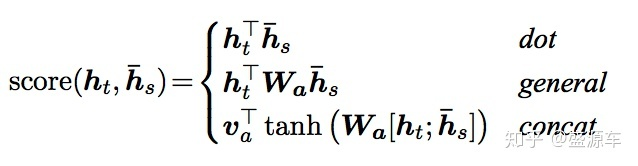

In [26]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, enc_hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hidden_size * 2, dec_hidden_size)

    def forward(self, x, lengths):
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx.long()]
        embedded = self.dropout(self.embed(x_sorted))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        out = out[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()
        # hid: [2, batch_size, enc_hidden_size]
        
        hid = torch.cat([hid[-2], hid[-1]], dim=1) # 将最后一层的hid的双向拼接
        # hid: [batch_size, 2*enc_hidden_size]
        hid = torch.tanh(self.fc(hid)).unsqueeze(0)
        # hid: [1, batch_size, dec_hidden_size]
        # out: [batch_size, seq_len, 2*enc_hidden_size]
        return out, hid

#### Luong Attention
- 根据context vectors和当前的输出hidden states，计算输出

这里我们计算第二种score的计算方法

In [27]:
class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        # enc_hidden_size跟Encoder的一样
        super(Attention, self).__init__()
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size

        self.linear_in = nn.Linear(enc_hidden_size*2, dec_hidden_size, bias=False)
        self.linear_out = nn.Linear(enc_hidden_size*2 + dec_hidden_size, dec_hidden_size)
        
    def forward(self, output, context, mask):
        # mask = batch_size, output_len, context_len     # mask在Decoder中创建好了
        # output: batch_size, output_len, dec_hidden_size，就是Decoder的output
        # context: batch_size, context_len, 2*enc_hidden_size，就是Encoder的output
        # 这里Encoder网络是双向的，Decoder是单向的
    
        batch_size = output.size(0)
        output_len = output.size(1)
        input_len = context.size(1) # input_len = context_len
        
        # 开始计算score，用到了第二种公式计算方式，先看懂这个网址：https://zhuanlan.zhihu.com/p/40920384
        # 通过decoder的hidden states加上encoder的hidden states来计算一个分数，用于计算权重
        context_in = self.linear_in(context.view(batch_size*input_len, -1)).view(                
            batch_size, input_len, -1) # batch_size, context_len, dec_hidden_size
        # 第一步，公式里的Wa先与hs做点乘，把Encoder output的enc_hidden_size换成dec_hidden_size。
        
        # context_in.transpose(1,2): batch_size, dec_hidden_size, context_len 
        # output: batch_size, output_len, dec_hidden_size
        attn = torch.bmm(output, context_in.transpose(1,2)) 
        # batch_size, output_len, context_len
        # 第二步，ht与上一步结果点乘，得到score

        attn.data.masked_fill(mask, -1e6)
        # .masked_fill作用请看这个链接：https://blog.csdn.net/candy134834/article/details/84594754
        # mask的维度必须和attn维度相同，mask为1的位置对应attn的位置的值替换成-1e6，
        # mask为1的意义需要看Decoder函数里面的定义

        attn = F.softmax(attn, dim=2) 
        # batch_size, output_len, context_len
        # 这个dim=2到底是怎么softmax的看下下面单元格例子
        # 第三步，计算每一个encoder的hidden states对应的权重。
        
        # context: batch_size, context_len, 2*enc_hidden_size，
        context = torch.bmm(attn, context) 
        # batch_size, output_len, 2*enc_hidden_size
        # 第四步，得出context vector是一个对于encoder输出的hidden states的一个加权平均
        
        # output: batch_size, output_len, dec_hidden_size
        output = torch.cat((context, output), dim=2) 
        # output：batch_size, output_len, 2*enc_hidden_size+dec_hidden_size
        # 第五步，将context vector和 decoder的hidden states 串起来。
        
        output = output.view(batch_size*output_len, -1)
        # output.shape = (batch_size*output_len, 2*enc_hidden_size+dec_hidden_size)
        output = torch.tanh(self.linear_out(output)) 
        # output.shape=(batch_size*output_len, dec_hidden_size)
        output = output.view(batch_size, output_len, -1)
        # output.shape=(batch_size, output_len, dec_hidden_size)
        # attn.shape = batch_size, output_len, context_len
        return output, attn

#### Decoder
- decoder会根据已经翻译的句子内容，和context vectors，来决定下一个输出的单词

In [34]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.out = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, x_len, y_len):
        # x_len 是一个batch中文句子的长度列表
        # y_len 是一个batch英文句子的长度列表
        # a mask of shape x_len * y_len
        device = x_len.device
        max_x_len = x_len.max()
        max_y_len = y_len.max()
        
        x_mask = torch.arange(max_x_len, device=device)[None, :] < x_len[:, None]
        # print(x_mask.shape) = (batch_size, output_len) # 中文句子的mask
        y_mask = torch.arange(max_y_len, device=device)[None, :] < y_len[:, None]
        # print(y_mask.shape) = (batch_size, context_len) # 英文句子的mask
        
        mask = ( ~ x_mask[:, :, None] * y_mask[:, None, :]).byte()
        # mask = (1 - x_mask[:, :, None] * y_mask[:, None, :]).byte()
        # 1-说明取反
        # x_mask[:, :, None] = (batch_size, output_len, 1)
        # y_mask[:, None, :] =  (batch_size, 1, context_len)
        # print(mask.shape) = (batch_size, output_len, context_len)
        # 注意这个例子的*相乘不是torch.bmm矩阵点乘，只是用到了广播机制而已。
        return mask
    
    def forward(self, encoder_out, x_lengths, y, y_lengths, hid):
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()]
        
        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, output_length, embed_size

        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()

        mask = self.create_mask(y_lengths, x_lengths) # 这里真是坑，第一个参数位置是中文句子的长度列表

        output, attn = self.attention(output_seq, encoder_out, mask) 
        # output.shape=(batch_size, output_len, dec_hidden_size)
        # attn.shape = batch_size, output_len, context_len
        
        # self.out = nn.Linear(dec_hidden_size, vocab_size)
        output = F.log_softmax(self.out(output), -1) # 计算最后的输出概率
        # output =(batch_size, output_len, vocab_size)
        # 最后一个vocab_size维度 log_softmax
        # hid.shape = (1, batch_size, dec_hidden_size)
        return output, hid, attn

#### Seq2Seq
- 最后我们构建Seq2Seq模型把encoder, attention, decoder串到一起

In [35]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        # print(hid.shape)=torch.Size([1, batch_size, dec_hidden_size])
        # print(out.shape)=torch.Size([batch_size, seq_len, 2*enc_hidden_size])
        output, hid, attn = self.decoder(encoder_out=encoder_out, 
                    x_lengths=x_lengths,
                    y=y,
                    y_lengths=y_lengths,
                    hid=hid)
        # output =(batch_size, output_len, vocab_size)
        # hid.shape = (1, batch_size, dec_hidden_size)
        # attn.shape = (batch_size, output_len, context_len)
        return output, attn
    

    def translate(self, x, x_lengths, y, max_length=100):
        encoder_out, hid = self.encoder(x, x_lengths)
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            output, hid, attn = self.decoder(encoder_out=encoder_out, 
                    x_lengths=x_lengths,
                    y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)
            y = output.max(2)[1].view(batch_size, 1)
            preds.append(y)
            attns.append(attn)
        return torch.cat(preds, 1), torch.cat(attns, 1)

训练

In [36]:
dropout = 0.2
embed_size = hidden_size = 100
encoder = Encoder(vocab_size=en_total_words,
                    embed_size=embed_size,
                    enc_hidden_size=hidden_size,
                    dec_hidden_size=hidden_size,
                    dropout=dropout)
decoder = Decoder(vocab_size=cn_total_words,
                    embed_size=embed_size,
                    enc_hidden_size=hidden_size,
                    dec_hidden_size=hidden_size,
                    dropout=dropout)
model = Seq2Seq(encoder, decoder)
model = model.to(device)
loss_fn = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [37]:
train(model, train_data, num_epochs=30)

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 0 iteration 0 loss 8.068070411682129


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 0 iteration 100 loss 5.277226448059082


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 0 iteration 200 loss 5.668028831481934


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 0 Training loss 5.462391946578691


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Evaluation loss 5.029999549712691
Epoch 1 iteration 0 loss 5.415362358093262


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 1 iteration 100 loss 4.836920261383057


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 1 iteration 200 loss 5.341506004333496


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 1 Training loss 4.828415614087521
Epoch 2 iteration 0 loss 4.984318256378174


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 2 iteration 100 loss 4.353861331939697


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 2 iteration 200 loss 4.996020317077637


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 2 Training loss 4.396189958301183
Epoch 3 iteration 0 loss 4.605762004852295


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 3 iteration 100 loss 3.948093891143799


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 3 iteration 200 loss 4.68315315246582


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 3 Training loss 4.034515408427965
Epoch 4 iteration 0 loss 4.295668601989746


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 4 iteration 100 loss 3.637524127960205


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 4 iteration 200 loss 4.455845832824707


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 4 Training loss 3.750665292436985
Epoch 5 iteration 0 loss 4.055205345153809


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 5 iteration 100 loss 3.3909733295440674


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 5 iteration 200 loss 4.247824668884277


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 5 Training loss 3.5187248368009123


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Evaluation loss 3.5309732463344865
Epoch 6 iteration 0 loss 3.8623013496398926


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 6 iteration 100 loss 3.2027928829193115


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 6 iteration 200 loss 4.093281269073486


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 6 Training loss 3.3255084381890914
Epoch 7 iteration 0 loss 3.6936633586883545


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 7 iteration 100 loss 3.0516278743743896


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 7 iteration 200 loss 3.973551034927368


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 7 Training loss 3.159019718552304
Epoch 8 iteration 0 loss 3.5671615600585938


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 8 iteration 100 loss 2.883467197418213


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 8 iteration 200 loss 3.849813938140869


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 8 Training loss 3.01271902550231
Epoch 9 iteration 0 loss 3.429774761199951


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 9 iteration 100 loss 2.720724582672119


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 9 iteration 200 loss 3.7807579040527344


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 9 Training loss 2.885403502733732
Epoch 10 iteration 0 loss 3.3139474391937256


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 10 iteration 100 loss 2.6684458255767822


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 10 iteration 200 loss 3.6891214847564697


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 10 Training loss 2.774916269074026


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Evaluation loss 3.080035245747708
Epoch 11 iteration 0 loss 3.2247633934020996


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 11 iteration 100 loss 2.5028138160705566


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 11 iteration 200 loss 3.6063287258148193


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 11 Training loss 2.6693351397340854
Epoch 12 iteration 0 loss 3.0973386764526367


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 12 iteration 100 loss 2.424257755279541


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 12 iteration 200 loss 3.4624860286712646


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 12 Training loss 2.573504643941627
Epoch 13 iteration 0 loss 3.0163142681121826


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 13 iteration 100 loss 2.325444221496582


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 13 iteration 200 loss 3.376875162124634


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 13 Training loss 2.493268056924075
Epoch 14 iteration 0 loss 3.0190677642822266


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 14 iteration 100 loss 2.293353319168091


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 14 iteration 200 loss 3.3327748775482178


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 14 Training loss 2.413494793382517
Epoch 15 iteration 0 loss 2.9086623191833496


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 15 iteration 100 loss 2.1990625858306885


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 15 iteration 200 loss 3.2558300495147705


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 15 Training loss 2.3475360012085296


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Evaluation loss 2.8878012477046515
Epoch 16 iteration 0 loss 2.821673631668091


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 16 iteration 100 loss 2.1432738304138184


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 16 iteration 200 loss 3.2153797149658203


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 16 Training loss 2.2787322770442766
Epoch 17 iteration 0 loss 2.813746690750122


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 17 iteration 100 loss 2.047699451446533


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 17 iteration 200 loss 3.2103235721588135


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 17 Training loss 2.2167438217554474
Epoch 18 iteration 0 loss 2.729219436645508


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 18 iteration 100 loss 1.990614652633667


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 18 iteration 200 loss 3.16267466545105


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 18 Training loss 2.165120675031011
Epoch 19 iteration 0 loss 2.680250883102417


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 19 iteration 100 loss 1.9171299934387207


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 19 iteration 200 loss 3.0855937004089355


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 19 Training loss 2.105722784446398
Epoch 20 iteration 0 loss 2.654689311981201


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 20 iteration 100 loss 1.8859118223190308


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 20 iteration 200 loss 3.041914701461792


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 20 Training loss 2.059865492387328


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Evaluation loss 2.7957506155350766
Epoch 21 iteration 0 loss 2.5519139766693115


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 21 iteration 100 loss 1.8735862970352173


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 21 iteration 200 loss 3.023750066757202


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 21 Training loss 2.0063688216416025
Epoch 22 iteration 0 loss 2.57476806640625


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 22 iteration 100 loss 1.7916518449783325


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 22 iteration 200 loss 2.948756217956543


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 22 Training loss 1.9675536106450735
Epoch 23 iteration 0 loss 2.5388054847717285


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 23 iteration 100 loss 1.770395040512085


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 23 iteration 200 loss 2.918182373046875


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 23 Training loss 1.9234432151243972
Epoch 24 iteration 0 loss 2.437464952468872


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 24 iteration 100 loss 1.691046953201294


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 24 iteration 200 loss 2.856987953186035


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 24 Training loss 1.882952037887668
Epoch 25 iteration 0 loss 2.413489580154419


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 25 iteration 100 loss 1.6806739568710327


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 25 iteration 200 loss 2.8448896408081055


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 25 Training loss 1.845102580410652


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Evaluation loss 2.754347846974447
Epoch 26 iteration 0 loss 2.4046998023986816


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 26 iteration 100 loss 1.616568684577942


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 26 iteration 200 loss 2.811371326446533


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 26 Training loss 1.8128432746298089
Epoch 27 iteration 0 loss 2.346560478210449


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 27 iteration 100 loss 1.6282302141189575


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 27 iteration 200 loss 2.753858804702759


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 27 Training loss 1.7754867688637976
Epoch 28 iteration 0 loss 2.3611369132995605


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 28 iteration 100 loss 1.5373119115829468


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 28 iteration 200 loss 2.7634708881378174


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 28 Training loss 1.7404916378135415
Epoch 29 iteration 0 loss 2.294869899749756


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 29 iteration 100 loss 1.5044001340866089


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 29 iteration 200 loss 2.734405040740967


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

Epoch 29 Training loss 1.708698423854948


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.


In [38]:
for i in range(100,120):
    translate_dev(i)
    print()

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

BOS you have nice skin . EOS
BOS 你 的 皮 膚 真 好 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

你有点光。

BOS you 're UNK correct . EOS
BOS 你 部 分 正 确 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

你是对的。

BOS everyone admired his courage . EOS
BOS 每 個 人 都 佩 服 他 的 勇 氣 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

每個人都有他的維氣。

BOS what time is it ? EOS
BOS 几 点 了 ？ EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

什么是什麼？

BOS i 'm free tonight . EOS
BOS 我 今 晚 有 空 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

我今晚有空。

BOS here is your book . EOS
BOS 這 是 你 的 書 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

這裡是你的書。

BOS they are at lunch . EOS
BOS 他 们 在 吃 午 饭 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

他們在午餐。

BOS this chair is UNK . EOS
BOS 這 把 椅 子 很 UNK 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

這個椅子是正在正在类。

BOS it 's pretty heavy . EOS
BOS 它 真 重 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

它很大的。

BOS many attended his funeral . EOS
BOS 很 多 人 都 参 加 了 他 的 葬 礼 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

許多人都有他的笔說。

BOS training will be provided . EOS
BOS 会 有 训 练 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

喝酒會會會很多。

BOS someone is watching you . EOS
BOS 有 人 在 看 著 你 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

有人在看看你。

BOS i slapped his face . EOS
BOS 我 摑 了 他 的 臉 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

我把他的臉儿。

BOS i like UNK music . EOS
BOS 我 喜 歡 流 行 音 樂 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

我喜歡在音樂。

BOS tom had no children . EOS
BOS T o m 沒 有 孩 子 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

汤姆没有孩子。

BOS please lock the door . EOS
BOS 請 把 門 鎖 上 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

请在門門。

BOS tom has calmed down . EOS
BOS 汤 姆 冷 静 下 来 了 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

汤姆已经上了。

BOS please speak more loudly . EOS
BOS 請 說 大 聲 一 點 兒 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

请講多難。

BOS keep next sunday free . EOS
BOS 把 下 周 日 空 出 来 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

繼續日語玩得很開心。

BOS i made a mistake . EOS
BOS 我 犯 了 一 個 錯 。 EOS


..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
..\aten\src\ATen\native\cuda\LegacyDefinitions.cpp:14: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool

我犯了一個錯。

